<img src="https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl-1024x576.png"
    style="padding-right:10px;width:140px;float:left">
<h2 style="white-space: nowrap">Neural Signal and Signal Processing (NX-421)</h2>
<hr style="clear:both">
<h1 style="colr:black">Miniproject 2 - Processing and analysis of EMG data</h1>
<h1 style="colr:black">Part 2</h1>
<h4 style="white-space: nowrap">Camille Dorster, Toufan Kashaev, Johan Bordet</h4>

## 1. Visualize & preprocess

In [1]:
import numpy as np
from scipy.io import loadmat
from scipy.signal import butter, sosfiltfilt
from scipy.ndimage import convolve1d

import os

np.random.seed(42)
random_state = 42

# NinaPro DB1 EMG sampling freq
fs = 100  # Hz

def bandpass_emg(emg, fs, bp=(5, 45)):
    sos_bp = butter(N=4, Wn=bp, fs=fs, btype="bandpass", output="sos")
    return sosfiltfilt(sos_bp, emg.T).T

def rectified_envelope(emg_filt, window_samples=25):
    emg_rect = np.abs(emg_filt)
    w = np.ones(window_samples) / window_samples
    return convolve1d(emg_rect, w, axis=0, mode="nearest")

def get_epochs(emg_env, stimulus, repetition, min_len=5):
    classes = np.unique(stimulus)
    classes = classes[classes != 0]        # remove rest
    reps = np.unique(repetition)
    reps = reps[reps != 0]                 # remove 0

    epochs, labels = [], []
    for c in classes:
        for r in reps:
            idx = np.logical_and(stimulus == c, repetition == r)
            if not np.any(idx):
                continue
            epoch = emg_env[idx, :]
            if epoch.shape[0] < min_len:
                continue
            epochs.append(epoch)
            labels.append(int(c))
    return epochs, np.array(labels)

def build_dataset_from_epochs(epochs, labels, feature_fns):
    n_samples = len(epochs)
    n_channels = epochs[0].shape[1]
    n_feat = len(feature_fns)

    X = np.zeros((n_samples, n_channels * n_feat))
    for i, ep in enumerate(epochs):
        blocks = [f(ep) for f in feature_fns]   # each (n_channels,)
        X[i, :] = np.stack(blocks, axis=0).reshape(-1)
    return X, labels.copy()

In [2]:
# --- features (5 per channel) ---
def mav(x): return np.mean(np.abs(x), axis=0)
def rms(x): return np.sqrt(np.mean(x**2, axis=0))
def var_feature(x): return np.var(x, axis=0)
def wl(x): return np.sum(np.abs(np.diff(x, axis=0)), axis=0)
def zc(x, threshold=1e-6):
    # NOTE: on rectified/envelope signals ZC often has low utility; kept for consistency with your request
    x1, x2 = x[:-1, :], x[1:, :]
    crossings = (x1 * x2) < 0
    amp_diff = np.abs(x2 - x1) > threshold
    return np.sum(crossings & amp_diff, axis=0)

feature_fns = [mav, rms, var_feature, wl, zc]

In [3]:
verbose = False
data_folder_name = "Data"

# Only keep directories (subjects)
subject_folders = sorted([
    folder for folder in os.listdir(data_folder_name)
    if os.path.isdir(os.path.join(data_folder_name, folder))
])

subjects = {}

for folder in subject_folders:
    folder_path = os.path.join(data_folder_name, folder)

    mat_files_a1e1 = [f for f in os.listdir(folder_path) if f.lower().endswith("a1_e1.mat")]
    mat_file = sorted(mat_files_a1e1)[0]

    path = os.path.join(folder_path, mat_file)
    data = loadmat(path)

    if "emg" not in data or "restimulus" not in data or "rerepetition" not in data:
        print(f"[WARN] Missing expected keys in {path}. Found keys: {list(data.keys())}")
        continue

    emg = data["emg"]                          # (T, n_channels)
    stimulus = data["restimulus"].ravel()      # (T,)
    repetition = data["rerepetition"].ravel()  # (T,)

    if verbose:
        print(f"\nSubject folder: {folder} | File: {mat_file}")
        print("EMG shape:", emg.shape)
        print("Stimulus labels:", np.unique(stimulus))
        print("Repetition ids:", np.unique(repetition))

    # preprocessing
    emg_filt = bandpass_emg(emg, fs, bp=(5, 45))
    emg_env = rectified_envelope(emg_filt, window_samples=25)

    # epoching
    epochs, labels = get_epochs(emg_env, stimulus, repetition, min_len=5)

    if len(epochs) == 0:
        print(f"[WARN] No valid epochs extracted for {folder} ({mat_file}), skipping.")
        continue

    # Feature extraction (one sample per epoch)
    X_sub, y_sub = build_dataset_from_epochs(epochs, labels, feature_fns)

    # store per-subject
    subjects[folder] = {
        "file": mat_file,
        "emg": emg,
        "stimulus": stimulus,
        "repetition": repetition,
        "emg_env": emg_env,
        "epochs": epochs,
        "labels": labels,
        "X": X_sub,
        "y": y_sub,
        "n_epochs": len(epochs),
        "n_channels": emg.shape[1],
        "feature_dim": X_sub.shape[1],
    }

print(f"Loaded {len(subjects)} subjects.")
if len(subjects) > 0:
    first_key = next(iter(subjects.keys()))
    print("Example subject:", first_key, "X shape:", subjects[first_key]["X"].shape)

subject_datasets = {}

for fname, sub in subjects.items():
    if "X" not in sub or "y" not in sub or sub["X"] is None:
        print(f"[WARN] {fname}: missing X/y, skipping.")
        continue

    X = sub["X"]
    y = sub["y"].astype(int)

    print(f"{fname}: X {X.shape}, y {y.shape}, classes {np.unique(y)}")
    subject_datasets[fname] = {"dataset": X, "labels": y}

Loaded 27 subjects.
Example subject: s1 X shape: (120, 50)
s1: X (120, 50), y (120,), classes [ 1  2  3  4  5  6  7  8  9 10 11 12]
s10: X (120, 50), y (120,), classes [ 1  2  3  4  5  6  7  8  9 10 11 12]
s11: X (120, 50), y (120,), classes [ 1  2  3  4  5  6  7  8  9 10 11 12]
s12: X (120, 50), y (120,), classes [ 1  2  3  4  5  6  7  8  9 10 11 12]
s13: X (120, 50), y (120,), classes [ 1  2  3  4  5  6  7  8  9 10 11 12]
s14: X (120, 50), y (120,), classes [ 1  2  3  4  5  6  7  8  9 10 11 12]
s15: X (120, 50), y (120,), classes [ 1  2  3  4  5  6  7  8  9 10 11 12]
s16: X (120, 50), y (120,), classes [ 1  2  3  4  5  6  7  8  9 10 11 12]
s17: X (120, 50), y (120,), classes [ 1  2  3  4  5  6  7  8  9 10 11 12]
s18: X (120, 50), y (120,), classes [ 1  2  3  4  5  6  7  8  9 10 11 12]
s19: X (120, 50), y (120,), classes [ 1  2  3  4  5  6  7  8  9 10 11 12]
s2: X (120, 50), y (120,), classes [ 1  2  3  4  5  6  7  8  9 10 11 12]
s20: X (120, 50), y (120,), classes [ 1  2  3  4  5  6 

## 2. Features comparison accross subjects

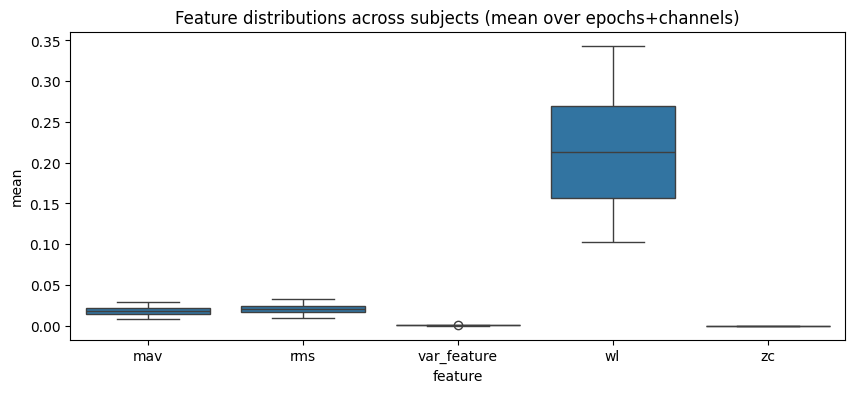

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rows = []
n_feat = len(feature_fns)
n_ch = next(iter(subjects.values()))["n_channels"]

for fname, data_pair in subject_datasets.items():
    X = data_pair["dataset"]
    subj_id = int("".join(ch for ch in fname if ch.isdigit()))

    # reshape to (n_epochs, n_feat, n_ch)
    Xr = X.reshape(X.shape[0], n_feat, n_ch)

    # aggregate across epochs and channels: mean per feature type
    feat_means = Xr.mean(axis=(0, 2))
    feat_stds  = Xr.std(axis=(0, 2))

    for fi, (m, s) in enumerate(zip(feat_means, feat_stds)):
        rows.append({"subject": subj_id, "feature": feature_fns[fi].__name__, "mean": m, "std": s})

df_feat = pd.DataFrame(rows)

plt.figure(figsize=(10,4))
sns.boxplot(data=df_feat, x="feature", y="mean")
plt.title("Feature distributions across subjects (mean over epochs+channels)")
plt.show()

## 3. Gradient boosting classification

#### Aggregate data across subjects (X_all, y_all, groups)

In [5]:
X_list, y_list, groups_list = [], [], []

for fname, data_pair in subject_datasets.items():
    X = data_pair["dataset"]
    y = data_pair["labels"]

    # subject id from folder name (e.g., "s27" -> 27)
    subj_id = int("".join([ch for ch in fname if ch.isdigit()]))

    X_list.append(X)
    y_list.append(y)
    groups_list.append(np.full(len(y), subj_id, dtype=int))

X_all = np.vstack(X_list)
y_all = np.concatenate(y_list).astype(int)
groups = np.concatenate(groups_list)

print("X_all shape:", X_all.shape)
print("y_all shape:", y_all.shape)
print("groups shape:", groups.shape)
print("Subjects present:", np.unique(groups))

X_all shape: (3240, 50)
y_all shape: (3240,)
groups shape: (3240,)
Subjects present: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]


### Subject-wise split: train subjects 1..26, test subject 27

In [6]:
train_subjects = np.arange(1, 27)   # 1..26
test_subjects = np.array([27])

train_mask = np.isin(groups, train_subjects)
test_mask  = np.isin(groups, test_subjects)

X_train_final = X_all[train_mask]
y_train_final = y_all[train_mask]
groups_train  = groups[train_mask]

X_test_final  = X_all[test_mask]
y_test_final  = y_all[test_mask]

print("Train:", X_train_final.shape, y_train_final.shape, "Subjects:", np.unique(groups_train))
print("Test :", X_test_final.shape, y_test_final.shape, "Subjects:", np.unique(groups[test_mask]))

# Safety checks
assert X_train_final.shape[0] == y_train_final.shape[0]
assert X_test_final.shape[0] == y_test_final.shape[0]

Train: (3120, 50) (3120,) Subjects: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Test : (120, 50) (120,) Subjects: [27]


### Standardization (fit train only)

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train_final)
X_test_z  = scaler.transform(X_test_final)

### Train and evaluate baseline Gradient Boosting

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

gb = GradientBoostingClassifier(random_state=random_state)

print("\nTraining Gradient Boosting...")
gb.fit(X_train_z, y_train_final)

y_test_pred = gb.predict(X_test_z)

test_accuracy = accuracy_score(y_test_final, y_test_pred)
test_f1_macro = f1_score(y_test_final, y_test_pred, average="macro")

print("\n--- FINAL EVALUATION (TEST: subject 27) ---")
print(f"Baseline test accuracy:  {test_accuracy:.4f}")
print(f"Baseline test macro-F1:  {test_f1_macro:.4f}")

gb_results = pd.DataFrame([
    ["Part 3 - Gradient Boosting", ""],
    ["Test Subject", f"{test_subjects[0]}"],
    ["Test Accuracy", f"{test_accuracy:.4f}"],
    ["Test Macro-F1", f"{test_f1_macro:.4f}"]
])
gb_results.to_csv(os.path.join(os.getcwd(), "Results", "Part2", "part3_gradient_boosting_results.csv"), index=False)


Training Gradient Boosting...

--- FINAL EVALUATION (TEST: subject 27) ---
Baseline test accuracy:  0.1917
Baseline test macro-F1:  0.1405


## 4. Cross-validation by rotating the test subject across all 27 subjects

In [9]:
from sklearn.model_selection import LeaveOneGroupOut, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("gb", HistGradientBoostingClassifier(random_state=random_state))
])

logo = LeaveOneGroupOut()

scores = cross_validate(
    pipe,
    X_all, y_all,
    cv=logo,
    groups=groups,
    scoring={"acc": "accuracy", "f1": "f1_macro"},
    n_jobs=-1,           # parallelize across folds (CPU cores)
    return_train_score=False
)

acc = scores["test_acc"]
f1  = scores["test_f1"]

print("LOSO accuracy mean ± std:", acc.mean(), acc.std())
print("LOSO macro-F1 mean ± std:", f1.mean(), f1.std())

gb_results = pd.DataFrame([
    ["LOSO accuracy mean ± std:", acc.mean(), acc.std()],
    ["LOSO macro-F1 mean ± std:", f1.mean(), f1.std()]
])
gb_results.to_csv(os.path.join(os.getcwd(), "Results", "Part2", "part4_cross_validation_results.csv"), index=False)


Traceback (most recent call last):
  File "/home/johhan/anaconda3/envs/NX-421/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"folder","base64_name" for automatic cleanup: unknown resource type ("L2Rldi9zaG0vam9ibGliX21lbW1hcHBpbmdfZm9sZGVyXzQ0NTM4Xzk5OTI5MmNkNGEyNDRlYmI5YmI1Y2ZjMGVkNjcyMTcwX2QwMTc0NDM4ZDk4NzQ3MWZiYzgxNjZlNGFlMzI5NjJj"}). Resource type should be one of the following: ['noop', 'folder', 'file', 'semlock']
Traceback (most recent call last):
  File "/home/johhan/anaconda3/envs/NX-421/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"semlock","base64_name" for automatic cleanup: unknown resource type ("L2xva3ktNDQ1Mzgta3ZrYzN5YzM="}). Resource type should be one of the following: ['noop'

LOSO accuracy mean ± std: 0.31759259259259265 0.10319817258938627
LOSO macro-F1 mean ± std: 0.26873233296892446 0.10476640720790126


## 5. Varying the number of training subjects

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("gb", HistGradientBoostingClassifier(random_state=random_state))
])

test_subj = 27
train_order = sorted([s for s in np.unique(groups) if s != test_subj])

X_test = X_all[groups == test_subj]
y_test = y_all[groups == test_subj]

accs, f1s, ks = [], [], []

for k in range(1, len(train_order) + 1):
    train_subjs = train_order[:k]
    train_mask = np.isin(groups, train_subjs)

    X_tr = X_all[train_mask]
    y_tr = y_all[train_mask]

    pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_test)

    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred, average="macro"))
    ks.append(k)

print("k subjects -> last acc, f1:", ks[-1], accs[-1], f1s[-1])


k subjects -> last acc, f1: 26 0.18333333333333332 0.13441850120588492


In [13]:
import pandas as pd
import os

# Build DataFrame
df_results = pd.DataFrame({
    "num_training_subjects": ks,
    "test_subject": test_subj,
    "test_accuracy": accs,
    "test_macro_f1": f1s,
})

# Output directory
out_dir = os.path.join(os.getcwd(), "Results", "Part2")
os.makedirs(out_dir, exist_ok=True)

out_path = os.path.join(out_dir, "part5_training_size_vs_performance.csv")

# Write CSV
df_results.to_csv(out_path, index=False)

print(f"Results saved to: {out_path}")


Results saved to: /home/johhan/github/NX-421_Miniproject_2/Results/Part2/part5_training_size_vs_performance.csv
